In [19]:
import torch
from torch import nn
import data_utils
from models.FenceGAN import Generator, Discriminator
from training.FenceGAN_train import train_kdd99, train_financial
import matplotlib.pyplot as plt

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


# Hyperparameters

In [3]:
# choose dataset (kdd99, aapl, gm, axp)
dataset = "aapl"

In [4]:
# Data
batch_size = 8
random_seed = 0
num_features = 7
seq_length = 30
seq_stride = 10
gen_seq_len = seq_length
# Model
latent_dim = 30
# Training
gen_lr = 1e-4
gen_wd = 1e-3
dis_lr = 8e-6
dis_wd = 1e-3
dis_momentum = 0.9
num_epochs = 50

# Dataset

In [5]:
if dataset == "kdd99":
    train_dl, test_dl = data_utils.kdd99(seq_length, seq_stride, num_features, gen_seq_len, batch_size)
else:
    file_path = 'data/financial_data/Stocks/'+dataset+'.us.txt'
    tscv_dl_list = data_utils.load_stock_as_crossvalidated_timeseries(file_path, seq_length, seq_stride, gen_seq_len, batch_size, normalise=True)

# Model 

In [6]:
# use xavier initialization for weights
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)   

In [7]:
generator = Generator(input_dim=latent_dim,output_dim=num_features).to(device=DEVICE)
generator.apply(init_weights)

Generator(
  (linear1): Linear(in_features=30, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=7, bias=True)
)

In [8]:
discriminator = Discriminator(input_dim=num_features).to(device=DEVICE)
discriminator.apply(init_weights)

Discriminator(
  (linear1): Linear(in_features=7, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=128, bias=True)
  (linear4): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

# Loss & Optimizer

In [9]:
generator_optim = torch.optim.Adam(generator.parameters(), lr=gen_lr, weight_decay=gen_wd)
discriminator_optim = torch.optim.SGD(discriminator.parameters(), lr=dis_lr, weight_decay=dis_wd)

In [10]:
def dispersion_loss(G_out, y_pred, y_true):
    dispersion_weight = 30
    loss_b = nn.BCELoss()(y_pred, y_true)
    center = G_out.mean(dim=0, keepdims=True)
    distance_xy = torch.square(torch.subtract(G_out, center))
    if G_out.dim() > 1:
        distance = distance_xy.sum(dim=1)
    else:
        distance = distance_xy.sum()
    avg_distance = torch.sqrt(distance).mean()
    loss_d = torch.reciprocal(avg_distance)
    loss = loss_b + dispersion_weight*loss_d
    return loss

In [11]:
def disc_loss(real_pred, real_true, fake_pred, fake_true):
    gen_weight = 0.5
    loss_real = nn.BCELoss()(real_pred, real_true)
    loss_gen = nn.BCELoss()(fake_pred, fake_true)
    loss = loss_real + gen_weight * loss_gen
    return loss

# Training & Evaluation

In [12]:
if dataset == "kdd99":
    train_kdd99(seq_length, latent_dim,  train_dl, test_dl, discriminator, generator, discriminator_optim, generator_optim, disc_loss, dispersion_loss, random_seed, num_epochs, DEVICE)
else:
    train_financial(seq_length, latent_dim, tscv_dl_list, discriminator, generator, discriminator_optim, generator_optim, disc_loss, dispersion_loss, random_seed, num_epochs, DEVICE)

Epoch 0: G_loss: 14.171849060058594, D_loss_real: 1.0874104022979736
Epoch 1: G_loss: 13.717059707641601, D_loss_real: 1.0906491041183473
Epoch 2: G_loss: 13.626070022583008, D_loss_real: 1.0890674591064453
Epoch 3: G_loss: 13.241706085205077, D_loss_real: 1.0907795906066895
Epoch 4: G_loss: 13.234391975402833, D_loss_real: 1.0874608755111694
Epoch 5: G_loss: 12.918296432495117, D_loss_real: 1.08627290725708
Epoch 6: G_loss: 12.576423835754394, D_loss_real: 1.090110683441162
Epoch 7: G_loss: 12.50947151184082, D_loss_real: 1.0883110523223878
Epoch 8: G_loss: 12.265491676330566, D_loss_real: 1.0947191953659057
Epoch 9: G_loss: 11.939357376098632, D_loss_real: 1.0927684307098389
Epoch 10: G_loss: 11.794884872436523, D_loss_real: 1.0912233591079712
Epoch 11: G_loss: 11.665547943115234, D_loss_real: 1.0883594274520874
Epoch 12: G_loss: 11.316099739074707, D_loss_real: 1.087226939201355
Epoch 13: G_loss: 11.248170852661133, D_loss_real: 1.086667799949646
Epoch 14: G_loss: 11.303798294067382

Epoch 18: G_loss: 2.726310913379376, D_loss_real: 1.1852722718165472
Epoch 19: G_loss: 2.66827339392442, D_loss_real: 1.1884437799453735
Epoch 20: G_loss: 2.580242762198815, D_loss_real: 1.1997636831723726
Epoch 21: G_loss: 2.561695172236516, D_loss_real: 1.202819356551537
Epoch 22: G_loss: 2.520363367520846, D_loss_real: 1.2039783184344952
Epoch 23: G_loss: 2.4742714441739597, D_loss_real: 1.2103060942429762
Epoch 24: G_loss: 2.4345204646770773, D_loss_real: 1.2007761368384728
Epoch 25: G_loss: 2.4330194363227258, D_loss_real: 1.2205511698356042
Epoch 26: G_loss: 2.3707835857684794, D_loss_real: 1.220529006077693
Epoch 27: G_loss: 2.3885453114142785, D_loss_real: 1.2163645304166353
Epoch 28: G_loss: 2.2858088199908915, D_loss_real: 1.2246845227021437
Epoch 29: G_loss: 2.286407571572524, D_loss_real: 1.2185662342951848
Epoch 30: G_loss: 2.260680813055772, D_loss_real: 1.2384856297419622
Epoch 31: G_loss: 2.2514089804429274, D_loss_real: 1.2370799137995794
Epoch 32: G_loss: 2.2236105662

Epoch 35: G_loss: 1.5233973264694214, D_loss_real: 1.1607326090335846
Epoch 36: G_loss: 1.5166160583496093, D_loss_real: 1.1607546508312225
Epoch 37: G_loss: 1.5256363570690155, D_loss_real: 1.1530764281749726
Epoch 38: G_loss: 1.5526260793209077, D_loss_real: 1.1509048283100127
Epoch 39: G_loss: 1.5395947873592377, D_loss_real: 1.1492606818675994
Epoch 40: G_loss: 1.5451572477817535, D_loss_real: 1.1494024515151977
Epoch 41: G_loss: 1.5481757521629333, D_loss_real: 1.1378233850002288
Epoch 42: G_loss: 1.5445178270339965, D_loss_real: 1.1512327015399932
Epoch 43: G_loss: 1.5628649175167084, D_loss_real: 1.13627188205719
Epoch 44: G_loss: 1.5506097614765166, D_loss_real: 1.1469104051589967
Epoch 45: G_loss: 1.5493963181972503, D_loss_real: 1.1450834810733794
Epoch 46: G_loss: 1.5476813077926637, D_loss_real: 1.1420717358589172
Epoch 47: G_loss: 1.5762043178081513, D_loss_real: 1.1452885925769807
Epoch 48: G_loss: 1.5675629377365112, D_loss_real: 1.140514212846756
Epoch 49: G_loss: 1.561

# Generated Samples

In [26]:
from training.FenceGAN_train import sample_Z
batch = next(iter(tscv_dl_list[4][1]))
latent_sample = sample_Z(batch_size, seq_length, latent_dim)
gen_sample = generator(latent_sample.to(DEVICE)).cpu().detach()[0]
x = batch[0][5]

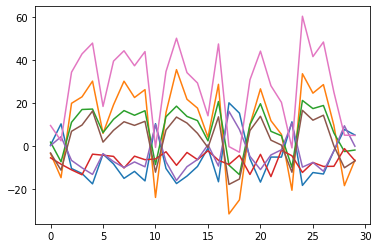

In [28]:
# generated Sample
plt.plot(gen_sample)

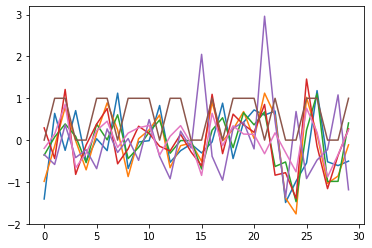

In [29]:
# Real Sample
plt.plot(x)